In [4]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [11]:
import cv2 as cv


In [6]:
!pip install matplotlib

In [7]:
import matplotlib.pyplot as plt

In [8]:
import cv2 as cv
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [9]:
inWidth = 368
inHeight = 368
thr = 0.2

In [11]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [69]:
 img = cv.imread("wp3.webp")

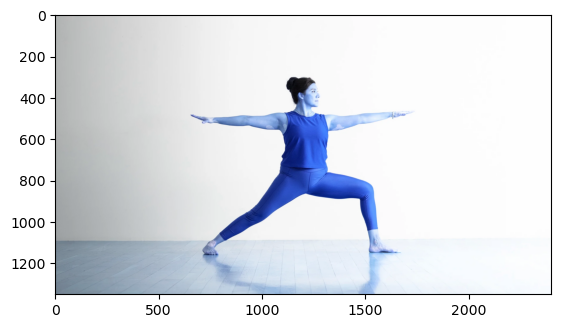

In [71]:
plt.imshow(img) #BGR

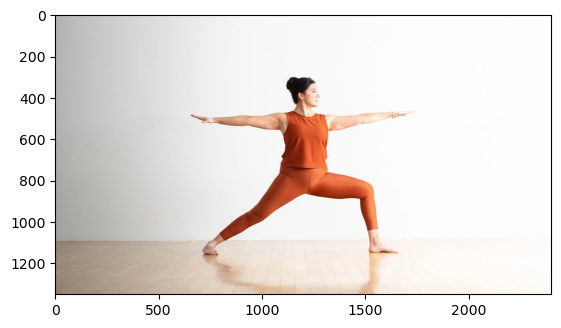

In [73]:
plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB)) # to RGB

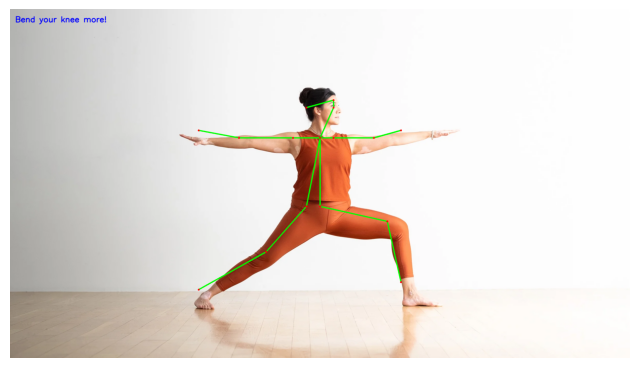

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load Pose Estimation Model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Define Model Parameters
inWidth = 368
inHeight = 368
thr = 0.2  # Confidence threshold

# Define Key Body Parts
BODY_PARTS = {
    "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
    "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
    "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
    "LEye": 15, "REar": 16, "LEar": 17, "Background": 18
}

POSE_PAIRS = [
    ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
    ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
    ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
    ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
    ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]
]

# Function to Calculate Angle Between Three Points
def calculate_angle(a, b, c):
    """Calculate the angle between three points (in degrees)."""
    a = np.array(a)  # First joint
    b = np.array(b)  # Middle joint (reference point)
    c = np.array(c)  # Last joint

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

# Function to Estimate Pose and Correct Yoga Posture
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Process image with the pose model
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # Extract only first 19 body parts

    points = []
    
    # Extract Key Points
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)

    # Draw Skeleton
    for pair in POSE_PAIRS:
        partFrom, partTo = pair
        idFrom, idTo = BODY_PARTS[partFrom], BODY_PARTS[partTo]
        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # YOGA POSE CORRECTION (Warrior Pose Example)
    feedback = "Pose not detected!"
    
    # Check if required keypoints exist
    if points[BODY_PARTS["LHip"]] and points[BODY_PARTS["LKnee"]] and points[BODY_PARTS["LAnkle"]]:
        knee_angle = calculate_angle(points[BODY_PARTS["LHip"]], points[BODY_PARTS["LKnee"]], points[BODY_PARTS["LAnkle"]])
        
        if 85 <= knee_angle <= 90:
            feedback = "Perfect Warrior Pose!"
        elif knee_angle > 90:
            feedback = "Bend your knee more!"
        elif knee_angle < 85:
            feedback = "Straighten your knee!"
    
    # Display Feedback on Image
    cv.putText(frame, feedback, (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv.LINE_AA)

    return frame

# Read Input Image
img = cv.imread("wp3.webp")

# Process Image with Pose Estimation
corrected_image = pose_estimation(img)

# Display the Image
plt.figure(figsize=(8, 6))
plt.imshow(cv.cvtColor(corrected_image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
